In [63]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import matplotlib.animation as animation

In [64]:
import torch

class CellSystem(torch.nn.Module):
    def __init__(self, num_cells=3):
        super().__init__()
        
        self.num_cells = num_cells  # Number of cells
        # Coefficients matrix: [x, y, radius, spring_constant]
        self.coefficients = torch.rand(num_cells, 4)  # Random initialization

        # Movement matrix for rotational motion + inward contraction
        self.movement = torch.tensor([
            [0.0, -1.0],  # dx/dt = -y (rotation)
            [1.0,  0.0]   # dy/dt = x  (rotation)
        ]) - 0.2 * torch.eye(2)  # Inward contraction for spiral

    def forward(self, t, state):
        # Compute velocity from the movement matrix (rotation + contraction)
        velocity = torch.matmul(state, self.movement.T)
        
        # Initialize repelling force matrix (each cell will repel every other cell)
        repelling_forces = torch.zeros_like(state)  # Initialize repelling forces to zero

        # Loop over all pairs of cells
        for i in range(self.num_cells):
            for j in range(i + 1, self.num_cells):  # Ensure no duplicate pairs
                # Calculate displacement between cell i and j
                displacement = state[j] - state[i]  # Vector from cell i to cell j
                distance = torch.norm(displacement) + 1e-6  # Avoid division by zero
                
                # Calculate radii and spring constants for both cells
                r_i, k_i = self.coefficients[i, 2], self.coefficients[i, 3]
                r_j, k_j = self.coefficients[j, 2], self.coefficients[j, 3]
                
                # Repelling force: Hooke's law based on distance, radii, and spring constants
                if distance < r_i + r_j:  # If distance is less than the sum of their radii
                    repelling_force = (k_i * (1.0 / distance - 1.0 / (r_i + r_j))) * (displacement / distance) * 2  # Adjust the force

                    # Apply repelling forces to both cells
                    repelling_forces[i] -= repelling_force
                    repelling_forces[j] += repelling_force
        
        # Add the repelling forces to the velocity (each cell gets adjusted)
        velocity += repelling_forces
        
        # Output: return positions (x, y), radius, spring constant, and velocity
        output = {
            "positions": state,  # [x, y] for each cell
            "radius": self.coefficients[:, 2],  # radius for each cell
            "spring_constant": self.coefficients[:, 3],  # spring constant for each cell
            "velocity": velocity  # velocity for each cell
        }
        
        return output


In [69]:
# Create model with a dynamic number of cells
num_cells = 3  # Change this number as needed
model = CellSystem(num_cells=num_cells)

# Dynamically create random initial positions within the [-1, 1] box for each cell
initial_state = 2 * torch.rand(num_cells, 2) - 1  # Random values between [-1, 1]

# Ensure initial_state has the shape (num_cells, 2)
assert initial_state.shape == (model.num_cells, 2), "Initial state dimensions mismatch."

# Time points (0 to 5 seconds, 50 points for smoother visualization)
t = torch.linspace(0, 15, 150)

# Solve ODE
with torch.no_grad():
    states = odeint(model, initial_state, t)

# Preview states tensor
print(states.shape)


torch.Size([150, 3, 2])


In [72]:
import pandas as pd

# Assume `states` has shape (num_time_steps, num_cells, 2) where the 2 is for x and y coordinates.
# `t` is the array of time steps.
num_cells = states.shape[1]  # Get the number of cells dynamically
num_time_steps = len(t)  # Number of time steps

# Initialize the list to hold the data
data = []

# Loop through each time step
for i in range(num_time_steps):
    # Loop through each cell
    for cell_id in range(num_cells):
        # Add position (x, y) for each time step
        data.append({
            "time": t[i].item(),
            "cell_id": cell_id,
            "factor_id": "x",  # Factor for x-coordinate
            "value": states[i, cell_id, 0].item(),  # x position
        })
        data.append({
            "time": t[i].item(),
            "cell_id": cell_id,
            "factor_id": "y",  # Factor for y-coordinate
            "value": states[i, cell_id, 1].item(),  # y position
        })

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("cell_trajectories.csv", index=False)

# Display first few rows of the DataFrame to verify
df.head()


,time,cell_id,factor_id,value
0,0.0,0,x,0.504651
1,0.0,0,y,0.582263
2,0.0,1,x,0.924688
3,0.0,1,y,0.945739
4,0.0,2,x,-0.803738


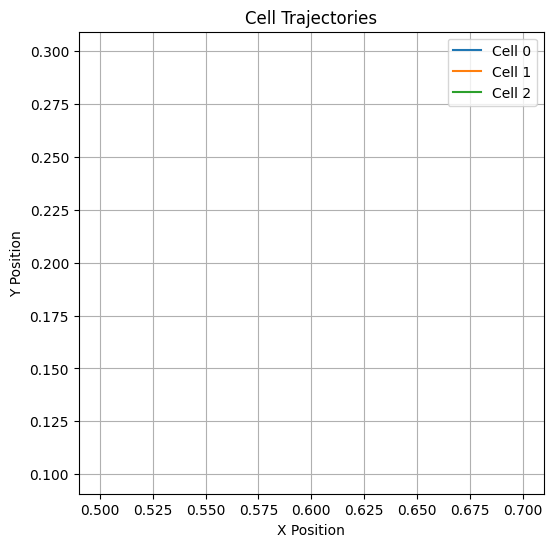

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("cell_trajectories.csv")

# Pivot data into (time, cell_id, factor_id) format to include x, y
df_pivot = df.pivot(index=["time", "cell_id"], columns="factor_id", values="value").reset_index()

# Ensure the columns are named correctly
df_pivot.columns = ["time", "cell_id", "x", "y", "radius", "spring_constant"]

# Create a plot
plt.figure(figsize=(6, 6))

# Loop through each cell and plot the trajectory
for cell_id in df_pivot["cell_id"].unique():
    df_cell = df_pivot[df_pivot["cell_id"] == cell_id]
    
    # Plot the trajectory (x, y)
    plt.plot(df_cell["x"], df_cell["y"], label=f"Cell {cell_id}")

# Labels and legend
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Cell Trajectories")
plt.legend(loc='upper right')
plt.grid(True)
plt.axis("equal")  # Keep aspect ratio square
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_27792\3237093929.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(cell_id / len(df_pivot["cell_id"].unique()))  # Color map based on cell_id


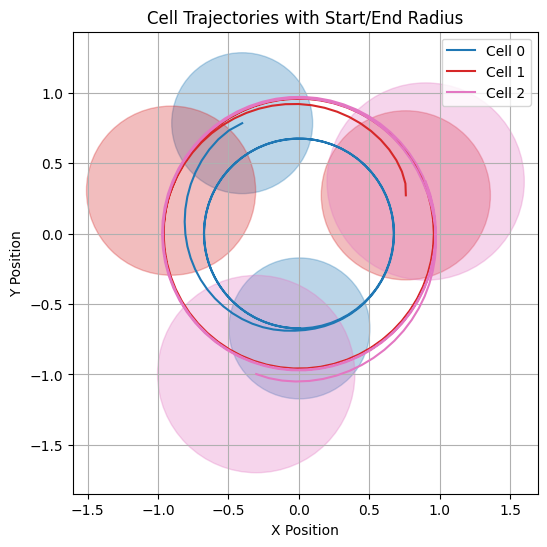

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # For drawing circles

# Load the data
df = pd.read_csv("cell_trajectories.csv")

# Pivot data into (time, cell_id, x, y) format
df_pivot = df.pivot(index=["time", "cell_id"], columns="coordinate_id", values="value").reset_index()
df_pivot.columns = ["time", "cell_id", "x", "y"]

# Assume we have the radius information saved in the coefficients (or define it)
# Here, we are assuming we have the radius data in a separate array for each cell (just an example)
radius_data = {
    0: 0.5,  # Cell 1 has radius 0.5
    1: 0.6,  # Cell 2 has radius 0.6
    2: 0.7,  # Cell 3 has radius 0.7
}

# Create a plot
plt.figure(figsize=(6, 6))

# Plot trajectories
for cell_id in df_pivot["cell_id"].unique():
    df_cell = df_pivot[df_pivot["cell_id"] == cell_id]
    
    # Generate a color for the trajectory (using a colormap or fixed color)
    color = plt.cm.get_cmap('tab10')(cell_id / len(df_pivot["cell_id"].unique()))  # Color map based on cell_id

    # Plot the trajectory
    plt.plot(df_cell["x"], df_cell["y"], label=f"Cell {cell_id}", color=color)

    # Get the starting and ending positions for the cell
    start_x, start_y = df_cell.iloc[0]["x"], df_cell.iloc[0]["y"]
    end_x, end_y = df_cell.iloc[-1]["x"], df_cell.iloc[-1]["y"]

    # Get the radius for the cell
    radius = radius_data.get(cell_id, 0.5)  # Default to 0.5 if not specified

    # Draw circles at the start and end positions with the same color as the trajectory
    circle_start = patches.Circle((start_x, start_y), radius, color=color, alpha=0.3)
    circle_end = patches.Circle((end_x, end_y), radius, color=color, alpha=0.3)
    
    # Add circles to the plot
    plt.gca().add_patch(circle_start)
    plt.gca().add_patch(circle_end)

# Labels and legend
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Cell Trajectories with Start/End Radius")
plt.legend(loc='upper right')
plt.grid(True)
plt.axis("equal")  # Keep aspect ratio square
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_27792\2884892185.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab10')(cell_id / len(df_pivot["cell_id"].unique()))


Animation saved as cell_trajectories_with_radii.gif


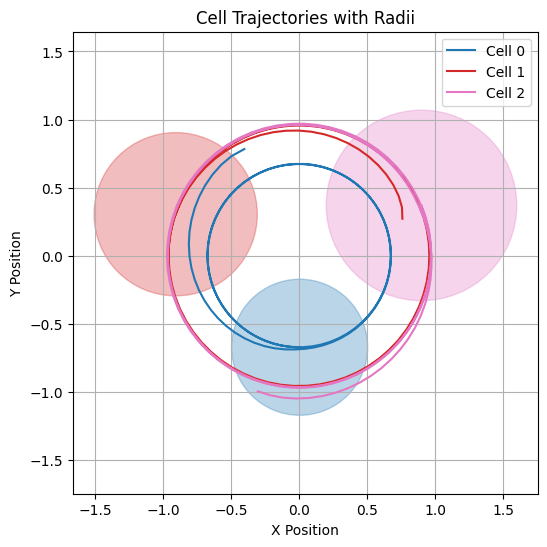

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# Load the data
df = pd.read_csv("cell_trajectories.csv")

# Pivot data into (time, cell_id, x, y, radius) format
df_pivot = df.pivot(index=["time", "cell_id"], columns="coordinate_id", values="value").reset_index()
df_pivot.columns = ["time", "cell_id", "x", "y"]

# Assuming the radius data is now part of the CSV (you can add this column to your CSV)
# If the radius is not included, you can add it manually or ensure it's part of the dataset
# We'll assume the radius is in a column called "radius"
# For example, assume each row has a "radius" column (you can create it in the CSV file if not)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_title("Cell Trajectories with Radii")
ax.grid(True)
ax.axis("equal")  # Keep aspect ratio square

# Define the function to update the plot at each time step
def update(frame):
    ax.clear()  # Clear previous frame
    
    # Plot trajectories and radii
    for cell_id in df_pivot["cell_id"].unique():
        df_cell = df_pivot[df_pivot["cell_id"] == cell_id]
        
        # Get the color for the current cell's trajectory
        color = plt.cm.get_cmap('tab10')(cell_id / len(df_pivot["cell_id"].unique()))
        
        # Plot the trajectory up to the current time point
        ax.plot(df_cell["x"].iloc[:frame+1], df_cell["y"].iloc[:frame+1], label=f"Cell {cell_id}", color=color)

        # Get the position and radius of the cell at the current time
        x, y = df_cell.iloc[frame]["x"], df_cell.iloc[frame]["y"]
        radius = df_cell.iloc[frame]["radius"]  # Extract radius from the dataframe
        
        # Draw a circle to represent the radius at the current position
        circle = patches.Circle((x, y), radius, color=color, alpha=0.3)
        ax.add_patch(circle)
    
    # Set limits and labels again after clearing
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    ax.set_title("Cell Trajectories with Radii")
    ax.legend()
    ax.grid(True)

# Number of frames is based on the number of unique time points
frames = len(df_pivot["time"].unique())

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, repeat=False)

# Save the animation
ani.save("cell_trajectories_with_radii.gif", writer="pillow")
print("Animation saved as cell_trajectories_with_radii.gif")

# Show the animation (in an interactive environment like Jupyter)
plt.show()
